Mini Project 2

# **Predictors of Autism in Adults**

**Sources:**
* https://archive.ics.uci.edu/dataset/426/autism+screening+adult
* https://www.kaggle.com/code/vishwasmishra1234/final-with-99-accuracy

In [1]:
#pip install ucimlrepo

### **Import data and Preview full dataset**

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
autism_screening_adult = fetch_ucirepo(id=426) 
  
# data (as pandas dataframes) 
X = autism_screening_adult.data.features 
y = autism_screening_adult.data.targets 
  
# metadata 
print(autism_screening_adult.metadata) 
  
# variable information 
print(autism_screening_adult.variables) 

{'uci_id': 426, 'name': 'Autism Screening Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/426/autism+screening+adult', 'data_url': 'https://archive.ics.uci.edu/static/public/426/data.csv', 'abstract': 'Autistic Spectrum Disorder Screening Data for Adult. This dataset is related to classification and predictive tasks.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': [], 'num_instances': 704, 'num_features': 20, 'feature_types': ['Integer'], 'demographics': ['Age', 'Gender', 'Ethnicity', 'Nationality'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C5F019', 'creators': ['Fadi Thabtah'], 'intro_paper': None, 'additional_info': {'summary': "See attached variables' description file ", 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': 

The *ASD-Tests app* uses the AQ-10 scoring rules for adults defined in 2012 by researchers at the University of Cambridge, lead by Professor Simon Baron-Cohen.

AQ-10 Questions:
A1_Score: I often notice small sounds when others do not.
A2_Score: I usually concentrate more on the whole picture, rather than the small details. (reverse scored)
A3_Score: I find it easy to do more than one thing at once. (reverse scored)
A4_Score: If there is an interruption, I can switch back to what I was doing very quickly. (reverse scored)
A5_Score: I find it easy to ‘read between the lines’ when someone is talking to me. (reverse scored)
A6_Score: I know how to tell if someone listening to me is getting bored. (reverse scored)
A7_Score: When I’m reading a story, I find it difficult to work out the characters’ intentions.
A8_Score: I like to collect information about categories of things (e.g., car types, bird species, train models).
A9_Score: I find it easy to work out what someone is thinking or feeling just by looking at their face. (reverse scored)
A10_Score: I find it difficult to work out people’s intentions.

### **Inspect categorical predictors**

In [3]:
# Categorical predictors
categorical_cols = [
    "gender","ethnicity","jaundice","family_pdd",
    "country_of_res","used_app_before","age_desc","relation"
]

# Inspect unique values and counts for each categorical column
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(X[col].value_counts(dropna=False))


--- gender ---
gender
m    367
f    337
Name: count, dtype: int64

--- ethnicity ---
ethnicity
White-European       233
Asian                123
NaN                   95
'Middle Eastern '     92
Black                 43
'South Asian'         36
Others                30
Latino                20
Hispanic              13
Pasifika              12
Turkish                6
others                 1
Name: count, dtype: int64

--- jaundice ---
jaundice
no     635
yes     69
Name: count, dtype: int64

--- family_pdd ---
family_pdd
no     613
yes     91
Name: count, dtype: int64

--- country_of_res ---
country_of_res
'United States'           113
'United Arab Emirates'     82
'New Zealand'              81
India                      81
'United Kingdom'           77
                         ... 
China                       1
Chile                       1
Lebanon                     1
Burundi                     1
Cyprus                      1
Name: count, Length: 67, dtype: int64

--- used_app_bef

In [4]:
X.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    int64  
 1   A2_Score         704 non-null    int64  
 2   A3_Score         704 non-null    int64  
 3   A4_Score         704 non-null    int64  
 4   A5_Score         704 non-null    int64  
 5   A6_Score         704 non-null    int64  
 6   A7_Score         704 non-null    int64  
 7   A8_Score         704 non-null    int64  
 8   A9_Score         704 non-null    int64  
 9   A10_Score        704 non-null    int64  
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        609 non-null    object 
 13  jaundice         704 non-null    object 
 14  family_pdd       704 non-null    object 
 15  country_of_res   704 non-null    object 
 16  used_app_before  704 non-null    object 
 17  result          

### **Import libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer 
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SequentialFeatureSelector

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error 
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.svm import SVC

### **Data Cleaning & Preprocessing Plan**
**Plan:**
1. Drop age_desc, it only contains 1 value ('18 and more').
2. Encode family_pdd, jaundice, sex, used_app_before: Yes=1, No=0
3. Missing Age: Impute two missing values from 'age' using median imputation.
4. Ethnicity:
    - combine others and Others, and rename NaN to Missing
    - Adding "Missing" category. 
    - Collapse rare categories into "Other" to reduce dimensionality.
5. Relation (who completed the questionnaire):
    - Add "Missing" category.
    - Collapse groupings: Parent + Relative become Parent_Relative. 'Health care professional' becomes Healthcare_provider

#### **Data Cleaning & Preprocessing: target variable**

In [6]:
## Data Cleaning & Preprocessing: target variable
# 1. Check target variable 
y_proc = y.copy()

# Inspect unique values and counts for each target variable
print(y_proc['class'].value_counts(dropna=False))

class
NO     515
YES    189
Name: count, dtype: int64


In [7]:
## Data Cleaning & Preprocessing: target variable
# 2. Standardise y ('class' column)
y_proc = y_proc.copy()

#  Map YES/NO to 1/0
y_proc['class'] = y_proc['class'].map({'YES': 1, 'NO': 0})

#  Handle any missing values explicitly (if present)
y_proc['class'] = y_proc['class'].fillna(-1)  # or 'Unknown' if you prefer categorical

# Quick check
print(y_proc['class'].value_counts(dropna=False))

class
0    515
1    189
Name: count, dtype: int64


In [8]:
## Data Cleaning & Preprocessing: target variable
# 3. Double check threshold used for raw data. Supposed to be >= 6
y_true = y_proc['class']
X_proc = X.copy()
scores = X_proc['result']

fpr, tpr, thresholds = roc_curve(y_true, scores)

# Find threshold that maximizes Youden’s J statistic (sensitivity + specificity - 1)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]
print("Best threshold for original 'result':", best_threshold)

# Evaluate thresholds 0-10
for t in range(0, 11):  # sum of AQ-10 scores ranges from 0–10

    y_pred = (scores >= t).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    print(f"Threshold {t}: Acc={acc:.2%}, Prec={prec:.2%}, Rec={rec:.2%}")

Best threshold for original 'result': 7.0
Threshold 0: Acc=26.85%, Prec=26.85%, Rec=100.00%
Threshold 1: Acc=28.84%, Prec=27.39%, Rec=100.00%
Threshold 2: Acc=33.52%, Prec=28.77%, Rec=100.00%
Threshold 3: Acc=44.03%, Prec=32.42%, Rec=100.00%
Threshold 4: Acc=59.66%, Prec=39.96%, Rec=100.00%
Threshold 5: Acc=78.27%, Prec=55.26%, Rec=100.00%
Threshold 6: Acc=90.06%, Prec=72.97%, Rec=100.00%
Threshold 7: Acc=100.00%, Prec=100.00%, Rec=100.00%
Threshold 8: Acc=91.90%, Prec=100.00%, Rec=69.84%
Threshold 9: Acc=84.09%, Prec=100.00%, Rec=40.74%
Threshold 10: Acc=77.41%, Prec=100.00%, Rec=15.87%


In [9]:
## Data Cleaning & Preprocessing: target variable
# 4. Confirm what we're seeing: threshold is really >=7, but source material uses >=6 ?
pred_6 = (X_proc['result'] >= 6).astype(int)
pred_7 = (X_proc['result'] >= 7).astype(int)

print("Agreement with class (>=6):", (pred_6 == y_proc['class']).mean())
print("Agreement with class (>=7):", (pred_7 == y_proc['class']).mean())

Agreement with class (>=6): 0.9005681818181818
Agreement with class (>=7): 1.0


In [10]:
## Data Cleaning & Preprocessing: target variable
# 5. Create a corrected target variable based on the raw result and REAL threshold of AQ10 score >=7
y_proc = y_proc.copy()

y_proc['class_corrected'] = (X_proc['result'] >= 7).astype(int)

# Quick check: how does it compare to the original class?
confusion = pd.crosstab(y_proc['class_corrected'], y_proc['class'],
                        rownames=['Corrected (>=7 rule)'],
                        colnames=['Original class'])

print(confusion)

# Agreement score
agreement = (y_proc['class_corrected'] == y_proc['class']).mean()
print(f"Agreement with original labels: {agreement:.2%}")

Original class          0    1
Corrected (>=7 rule)          
0                     515    0
1                       0  189
Agreement with original labels: 100.00%


### **Data cleaning: predictor variables**

In [11]:
## Data Cleaning: age - missing values
# 1. Deal with age values: missing or bad data (NaN, 383.0). Change from float to integer

# Flag implausible ages
invalid_age_mask = (X_proc['age'] < 16) | (X_proc['age'] > 100)
print("Invalid ages found:", X_proc.loc[invalid_age_mask, 'age'])

# set invalid ages to NaN
X_proc.loc[invalid_age_mask, 'age'] = np.nan

# .. impute later with median
median_age = X_proc['age'].median()
X_proc['age'] = X_proc['age'].fillna(median_age)

# change data type to integer
X_proc['age'] = X_proc['age'].round().astype('Int64')

# Recheck age, validate there are no more NaN
print("Any NaNs in age?", X_proc['age'].isna().any())
print("Total NaNs in age:", X_proc['age'].isna().sum())

Invalid ages found: 52    383.0
Name: age, dtype: float64
Any NaNs in age? False
Total NaNs in age: 0


In [12]:
## Data Cleaning: age_desc - drop
# 2. Drop age_desc since it has only one unique value
X_proc = X_proc.copy()

X_proc = X_proc.drop(columns=["age_desc"])

#  Quick check
print("Remaining columns:", X_proc.columns.tolist())

Remaining columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jaundice', 'family_pdd', 'country_of_res', 'used_app_before', 'result', 'relation']


In [13]:
## 3. Data cleaning: country_of_res - standardise

# Standardise country_of_res by stripping and removing spaces
X_proc = X_proc.copy()

# Remove leading/trailing whitespace, then remove *all* spaces inside names
X_proc['country_of_res'] = (
    X_proc['country_of_res']
    .astype(str)                # ensure string type
    .str.strip()                # remove leading/trailing spaces
    .str.replace(" ", "", regex=False)  # remove all spaces
    .str.replace("'", "", regex=False)    # remove apostrophes
)

# Check
X_proc['country_of_res'].value_counts(dropna=False)

country_of_res
UnitedStates          113
UnitedArabEmirates     82
NewZealand             81
India                  81
UnitedKingdom          77
                     ... 
China                   1
Chile                   1
Lebanon                 1
Burundi                 1
Cyprus                  1
Name: count, Length: 67, dtype: int64

### **Feature Engineering**

#### **Preprocessing: binary predictors**

In [14]:
## Preprocessing: categorical data to binary: family_pdd
# 1. Standardize and encode family_pdd
X_proc = X_proc.copy()

#  Map yes/no to 1/0
X_proc['family_pdd'] = X_proc['family_pdd'].map({'yes': 1, 'no': 0})

#  Handle any missing values explicitly (if present)
X_proc['family_pdd'] = X_proc['family_pdd'].fillna(-1)  # or 'Unknown' if you prefer categorical

# Quick check
print(X_proc['family_pdd'].value_counts(dropna=False))

family_pdd
0    613
1     91
Name: count, dtype: int64


In [15]:
## Preprocessing: categorical data to binary: jaundice
# 2. Standardize and encode jaundice
X_proc = X_proc.copy()

#  Map yes/no to 1/0
X_proc['jaundice'] = X_proc['jaundice'].map({'yes': 1, 'no': 0})

#  Handle any missing values explicitly (if present)
X_proc['jaundice'] = X_proc['jaundice'].fillna(-1)  # or 'Unknown' if you prefer categorical

# Quick check
print(X_proc['jaundice'].value_counts(dropna=False))

jaundice
0    635
1     69
Name: count, dtype: int64


In [16]:
## Preprocessing: categorical data to binary: used_app_before
# 3. Standardize and encode used_app_before
X_proc = X_proc.copy()

#  Map yes/no to 1/0
X_proc['used_app_before'] = X_proc['used_app_before'].map({'yes': 1, 'no': 0})

#  Handle any missing values explicitly (if present)
X_proc['used_app_before'] = X_proc['used_app_before'].fillna(-1)  # or 'Unknown' if you prefer categorical

# Quick check
print(X_proc['used_app_before'].value_counts(dropna=False))

used_app_before
0    692
1     12
Name: count, dtype: int64


In [17]:
## Preprocessing: categorical data to binary: gender >> sex
# 4. Standardize and encode gender >>> sex (genders aren't m or f
X_proc = X_proc.copy()

# Rename column
X_proc = X_proc.rename(columns={"gender": "sex"})

#  Map f/m to 1/0
X_proc['sex'] = X_proc['sex'].map({'f': 1, 'm': 0})

#  Handle any missing values explicitly (if present)
X_proc['sex'] = X_proc['sex'].fillna(-1)  # or 'Unknown' if you prefer categorical

# Quick check
print(X_proc['sex'].value_counts(dropna=False))

sex
0    367
1    337
Name: count, dtype: int64


In [18]:
## Preprocessing: binary data: Check all
# 5. recheck categorical columns after converting to binary etc


# jaundice, family_pdd, used_app_before:
# 1 = Yes, 0 = No

# sex:
# 1 = female, 0 = male


# Define the AQ-10 item columns
aq_scores = [f"A{i}_Score" for i in range(1, 11)]

binary_cols = aq_scores+["sex","jaundice","family_pdd","used_app_before"]

# Inspect unique values and counts for each binary column
for col in binary_cols:
    print(f"\n--- {col} ---")
    print(X_proc[col].value_counts(dropna=False))


--- A1_Score ---
A1_Score
1    508
0    196
Name: count, dtype: int64

--- A2_Score ---
A2_Score
0    385
1    319
Name: count, dtype: int64

--- A3_Score ---
A3_Score
0    382
1    322
Name: count, dtype: int64

--- A4_Score ---
A4_Score
0    355
1    349
Name: count, dtype: int64

--- A5_Score ---
A5_Score
0    353
1    351
Name: count, dtype: int64

--- A6_Score ---
A6_Score
0    504
1    200
Name: count, dtype: int64

--- A7_Score ---
A7_Score
0    410
1    294
Name: count, dtype: int64

--- A8_Score ---
A8_Score
1    457
0    247
Name: count, dtype: int64

--- A9_Score ---
A9_Score
0    476
1    228
Name: count, dtype: int64

--- A10_Score ---
A10_Score
1    404
0    300
Name: count, dtype: int64

--- sex ---
sex
0    367
1    337
Name: count, dtype: int64

--- jaundice ---
jaundice
0    635
1     69
Name: count, dtype: int64

--- family_pdd ---
family_pdd
0    613
1     91
Name: count, dtype: int64

--- used_app_before ---
used_app_before
0    692
1     12
Name: count, dtype: in

#### **Preprocessing: score threshold for class assignment**

In [19]:
## Preprocessing: numerical data - validate result is sum of AQ-10 scores 
# 1. Calculate the sum of all AQ-10 Score columns

item_cols = [c for c in X_proc.columns if c.startswith("A") and c.endswith("_Score")]

X_proc['sum_check'] = X_proc[item_cols].sum(axis=1)

# Compare with the provided 'result'
mismatches = (X_proc['sum_check'] != X_proc['result']).sum()
print(f"Mismatched rows: {mismatches}")

# Optional: inspect a few mismatches if any
if mismatches > 0:
    print(X_proc.loc[X_proc['sum_check'] != X_proc['result'],
                     item_cols + ['result','sum_check']].head())

Mismatched rows: 0


In [20]:
# 2. Drop sum_check, don't need it now

X_proc = X_proc.drop(columns=["sum_check"])

There *should be* **259** *cases of Class=1*, *there are only* **189** *cases.* Here we see that all of the result scores of 6 ***are not*** mapped to class =1 at all, contradicting the given information about the score threshold for class assignment. 

In [21]:
# 3. Rebuild df_plot
df_plot = X.join(y)

# Crosstab of result vs class, restricted to results 6–10
scores = [6, 7, 8, 9, 10]
counts = pd.crosstab(
    df_plot.loc[df_plot['result'].isin(scores), 'result'],
    df_plot.loc[df_plot['result'].isin(scores), 'class']
)

print(counts)


class   NO  YES
result         
6       70    0
7        0   57
8        0   55
9        0   47
10       0   30


#### **Preprocessing: categorical predictors**

In [22]:
## Preprocessing: categorical data - age 
# 1. Categorical data: age

X_proc['age_bin'] = pd.cut(
    X_proc['age'],
    bins=[16, 24, 34, 49, 64],
    labels=['17-24', '25-34', '35-49', '50-64']
)

# 2. Count per age_bin
bin_counts = X_proc['age_bin'].value_counts().sort_index()

print(bin_counts)


age_bin
17-24    287
25-34    237
35-49    146
50-64     34
Name: count, dtype: int64


In [23]:
## Preprocessing: categorical data - ethnicity
# 2. Categorical data: ethnicity

# Make a clean copy
X_proc = X_proc.copy()

print("\nBefore standardising:", X_proc['ethnicity'].value_counts(dropna=False)) 

#  Standardize ethnicity values by collapsing less common ethnicities
X_proc['ethnicity'] = (
    X_proc['ethnicity']
    .replace({
        'White-European': 'EuropeanDescent',
        'Black': 'AfricanDescent',   
        "'Middle Eastern '": 'MiddleEastern',
        "'South Asian'": 'SouthAsian',
        'others': 'Other',
        'Others': 'Other',
        'Hispanic': 'Other',
        'Pasifika': 'Other',
        'Turkish': 'Other'
    })
    .fillna('Missing')  # replace NaN with 'Missing'
)

print("\nAfter standardising:", X_proc['ethnicity'].value_counts(dropna=False)) 


Before standardising: ethnicity
White-European       233
Asian                123
NaN                   95
'Middle Eastern '     92
Black                 43
'South Asian'         36
Others                30
Latino                20
Hispanic              13
Pasifika              12
Turkish                6
others                 1
Name: count, dtype: int64

After standardising: ethnicity
EuropeanDescent    233
Asian              123
Missing             95
MiddleEastern       92
Other               62
AfricanDescent      43
SouthAsian          36
Latino              20
Name: count, dtype: int64


In [24]:
## Preprocessing: categorical data - country_of_res
# 3. Categorical data: country_of_res - map to new feature: "region_of_res"

# Make a clean copy
X_proc = X_proc.copy()

print("\nBefore standardising:", X_proc['country_of_res'].value_counts(dropna=False))

# Define a mapping from country to region
# 
country_to_region = {
    # Africa
     "Angola": "Africa", "Burundi": "Africa", "Egypt": "Africa", "Ethiopia": "Africa", "Niger": "Africa", "Nigeria": "Africa", "SierraLeone": "Africa", "SouthAfrica": "Africa",
    # EastAsia
     "China": "EastAsia", "Japan": "EastAsia",
    # EasternEurope
     "CzechRepublic": "EasternEurope", "Romania": "EasternEurope", "Serbia": "EasternEurope", "Ukraine": "EasternEurope",
    # Eurasia
     "Russia": "Eurasia", "Turkey": "Eurasia",
    # CentralAmerica
     "Aruba": "CentralAmerica", "Bahamas": "CentralAmerica", "CostaRica": "CentralAmerica", "Nicaragua": "CentralAmerica",
    # MiddleEast
     "Afghanistan": "MiddleEast", "Armenia": "MiddleEast", "Azerbaijan": "MiddleEast", "Iraq": "MiddleEast", "Iran": "MiddleEast", "Jordan": "MiddleEast",
     "Kazakhstan": "MiddleEast", "Lebanon": "MiddleEast", "Oman": "MiddleEast", "SaudiArabia": "MiddleEast", "UnitedArabEmirates": "MiddleEast",
    # NorthAmerica
     "Canada": "NorthAmerica", "Mexico": "NorthAmerica", "UnitedStates": "NorthAmerica",
    # Oceania
     "AmericanSamoa": "Oceania", "Australia": "Oceania", "NewZealand": "Oceania", "Tonga": "Oceania",
    # Scandinavia
     "Finland": "Scandinavia", "Iceland": "Scandinavia", "Sweden": "Scandinavia",
    # SouthAmerica
     "Argentina": "SouthAmerica", "Bolivia": "SouthAmerica", "Brazil": "SouthAmerica", "Chile": "SouthAmerica", "Ecuador": "SouthAmerica", "Uruguay": "SouthAmerica",
    # SouthAsia
     "Bangladesh": "SouthAsia", "India": "SouthAsia", "Nepal": "SouthAsia", "Pakistan": "SouthAsia", "SriLanka": "SouthAsia",
    # SoutheastAsia
     "HongKong": "SoutheastAsia", "Indonesia": "SoutheastAsia", "Malaysia": "SoutheastAsia", "Philippines": "SoutheastAsia", "VietNam": "SoutheastAsia",
    #SouthernEurope    
     "Cyprus": "SouthernEurope", "Italy": "SouthernEurope",
    # WesternEurope
     "Austria": "WesternEurope", "Belgium": "WesternEurope", "France": "WesternEurope", "Germany": "WesternEurope", "Ireland": "WesternEurope", "Netherlands": "WesternEurope", 
     "Portugal": "WesternEurope", "Spain": "WesternEurope", "UnitedKingdom": "WesternEurope"
}

# Apply the mapping
X_proc['region_of_res'] = X_proc['country_of_res'].map(country_to_region)

# Handle unmapped countries
X_proc['region_of_res'] = X_proc['region_of_res'].fillna("Other")

print("\nAfter standardising:", X_proc['region_of_res'].value_counts(dropna=False))


Before standardising: country_of_res
UnitedStates          113
UnitedArabEmirates     82
NewZealand             81
India                  81
UnitedKingdom          77
                     ... 
China                   1
Chile                   1
Lebanon                 1
Burundi                 1
Cyprus                  1
Name: count, Length: 67, dtype: int64

After standardising: region_of_res
MiddleEast        162
NorthAmerica      136
WesternEurope     118
Oceania           111
SouthAsia         102
SoutheastAsia      16
SouthAmerica       15
Africa             11
Eurasia             8
EasternEurope       7
SouthernEurope      6
CentralAmerica      5
Scandinavia         5
EastAsia            2
Name: count, dtype: int64


In [25]:
## Preprocessing: categorical data - relation
# 4. Standardise relation

X_proc = X_proc.copy()

print("\nBefore standardising:", X_proc['relation'].value_counts(dropna=False)) 

X_proc['relation'] = (
    X_proc['relation']
    .replace({
        'Parent': 'Parent_Relative',
        'Relative': 'Parent_Relative',
        "'Health care professional'": 'Healthcare_provider',
        'Others': 'Other'
    })
    .fillna('Missing')
)

print("\nAfter standardising:", X_proc['relation'].value_counts(dropna=False)) 


Before standardising: relation
Self                          522
NaN                            95
Parent                         50
Relative                       28
Others                          5
'Health care professional'      4
Name: count, dtype: int64

After standardising: relation
Self                   522
Missing                 95
Parent_Relative         78
Other                    5
Healthcare_provider      4
Name: count, dtype: int64


### **EDA**

In [26]:
# Redefine X & y

X = X_proc.copy()
y = y_proc['class']

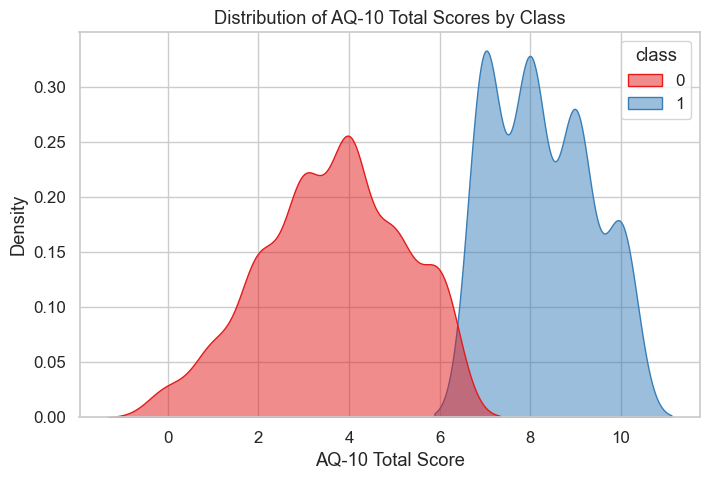

In [27]:
# 1. Distribution of AQ-10 Total Scores by class

# Set a colourful style
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# 1. AQ-10 totals Scores ('result')  by Class
plt.figure(figsize=(8,5))
sns.kdeplot(data=X.join(y), x="result", hue=y, fill=True, common_norm=False, palette="Set1", alpha=0.5)
plt.title("Distribution of AQ-10 Total Scores by Class")
plt.xlabel("AQ-10 Total Score")
plt.ylabel("Density")
plt.savefig("distribution_totals_vs_Class2.png")
plt.show()

**Observations on distribution plot:**
There is some crossover between Class 0 (autism is not indicated), and Class 1 (autism is indicated), where AQ-Total Score between 6-7. The published threshold for Class 1 is an AQ-Total Score of >=6. This graph may indicate misclassification, which we have already seen based on the number of total class=1 cases we would expect to see if the real threshold was score totals >=6.

C:\Users\dell\AppData\Local\Temp\ipykernel_15340\41607161.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="result", data=df_plot, palette="Set2")


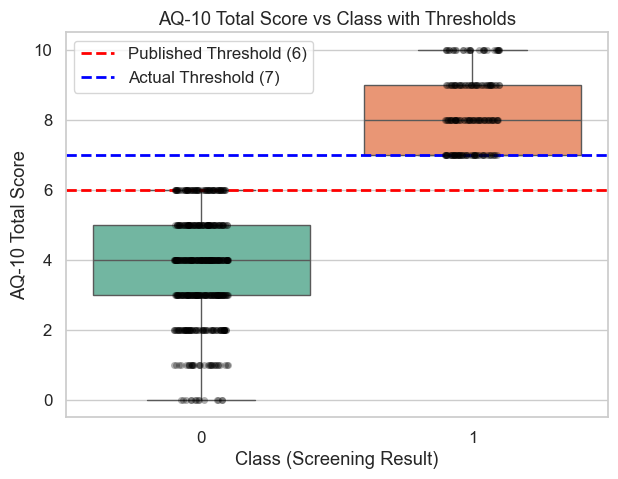

In [28]:
# 2. Boxplot of AQ-10 Total Scores by class vs published and actual thresholds
df_plot = X.join(y.rename("class"))

plt.figure(figsize=(7,5))
sns.boxplot(x="class", y="result", data=df_plot, palette="Set2")
sns.stripplot(x=y, y=X["result"], color="black", alpha=0.3, jitter=True)

# Add published threshold line
plt.axhline(6, color="red", linestyle="--", linewidth=2, label="Published Threshold (6)")

# Add identified threshold line
plt.axhline(7, color="blue", linestyle="--", linewidth=2, label="Actual Threshold (7)")

plt.title("AQ-10 Total Score vs Class with Thresholds")
plt.xlabel("Class (Screening Result)")
plt.ylabel("AQ-10 Total Score")
plt.legend()
plt.savefig("boxplot_totals_vs_thresholds2.png")
plt.show()

**Observations on box plot:**
This is consistent with the first plot: all Class 1 values are represented above threshold 7. Class 0 values have an upper extreme of 6, as discussed these cases could easily have been included in Class 1.

#### **Redefine AQ-10 score threshold for class assignment** ... then continue EDA

In [29]:
# 1. Redefine threshold

# Flip class from 0 → 1 where result == 6
y.loc[(X['result'] == 6) & (y == 0)] = 1

# Rebuild df_plot
df_plot = X.join(y)

In [30]:
# 2. Check update to df_plot
# AFTER THRESHOLD CHANGE: Crosstab of result vs class, restricted to results 6–10
scores = [6, 7, 8, 9, 10]
counts = pd.crosstab(
    df_plot.loc[df_plot['result'].isin(scores), 'result'],
    df_plot.loc[df_plot['result'].isin(scores), 'class']
)

print(counts)

class    1
result    
6       70
7       57
8       55
9       47
10      30


### **All features Where Class=1, After Feature Engineering & before Feature Selection**

In [31]:
## Build dataframe for plotting
df = X.join(y.rename("class"))

In [32]:
## step 2: Selected features BEFORE feature selection

# Selected binary features
aq_scores = [f"A{i}_Score" for i in range(1, 11)]

binary_feats = aq_scores+["sex","jaundice","family_pdd","used_app_before"]

# Categorical features
cat_feats = ["ethnicity", "region_of_res", "relation", "age_bin"]

In [33]:
## step 3: Compute conditional probabilities on the full engineered set

results = []
baseline = df['class'].mean()

# Categorical features: compare each category to baseline
for col in cat_feats:
    if col not in df.columns:
        print(f"Skipping missing categorical feature: {col}")
        continue
    for cat in df[col].dropna().unique():
        rate = df.loc[df[col] == cat, 'class'].mean()
        diff = rate - baseline
        results.append({"feature": col, "category": str(cat), "diff": diff})

# Binary features: compare class=1 rate when feature=1 vs 0
for feat in binary_feats:
    if feat not in df.columns:
        print(f"Skipping missing binary feature: {feat}")
        continue
    rates = df.groupby(feat)['class'].mean()
    if 1 in rates and 0 in rates:
        diff = rates[1] - rates[0]
        results.append({"feature": feat, "category": "1 vs 0", "diff": diff})
    else:
        print(f"Skipping {feat}: missing 0/1 values")


In [34]:
## step 4: Prep for plots
summary_df = pd.DataFrame(results)

# Combine feature + category for labeling
summary_df['label'] = summary_df['feature'] + ": " + summary_df['category']

# Sort by absolute effect size
summary_df = summary_df.sort_values("diff", key=abs, ascending=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_15340\1032189987.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


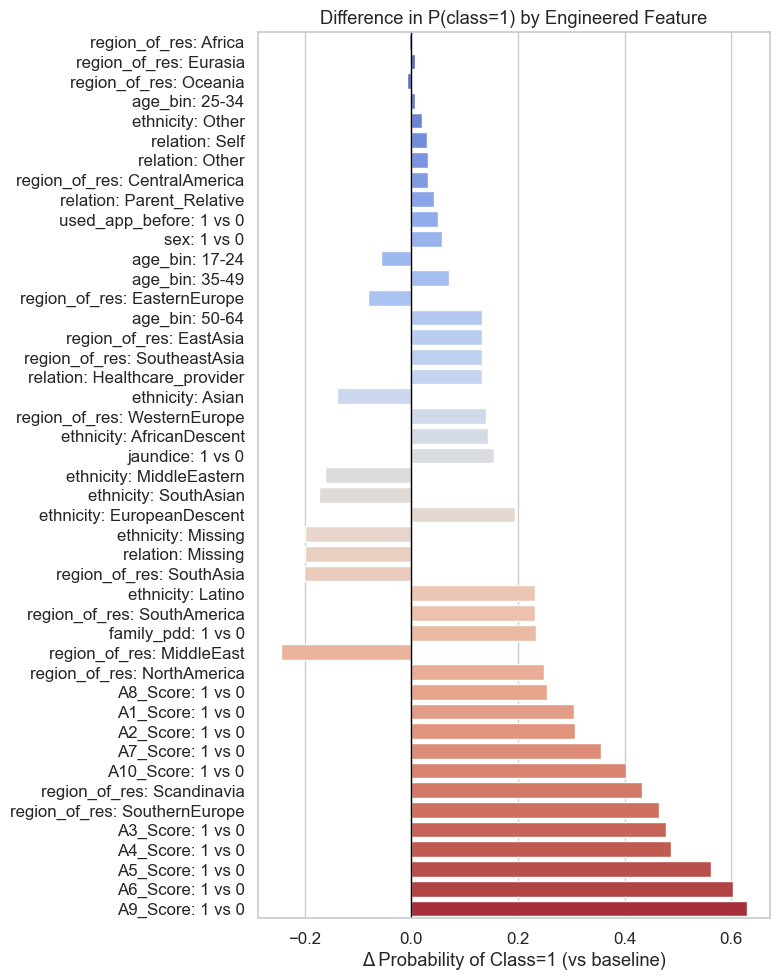

In [35]:
## step 5: Plot horizontal barplot - engineered features

plt.figure(figsize=(8, 10))
sns.barplot(
    data=summary_df,
    y="label", x="diff",
    palette="coolwarm", orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Difference in P(class=1) by Engineered Feature")
plt.xlabel("Δ Probability of Class=1 (vs baseline)")
plt.ylabel("")
plt.tight_layout()

# Save high-res for PowerPoint
plt.savefig("all_features_effects4.png", dpi=300, bbox_inches="tight")
plt.show()

Observations on desc barplot of probability strengths for Class=1: top 13 include all 10 AQ-10 scores, and 3 regions of residence: SouthernEurope, Scandinavia, and NorthAmerica.
Residing in the Middle East is least predictive of Class=1.

### **EDA ... resumed**

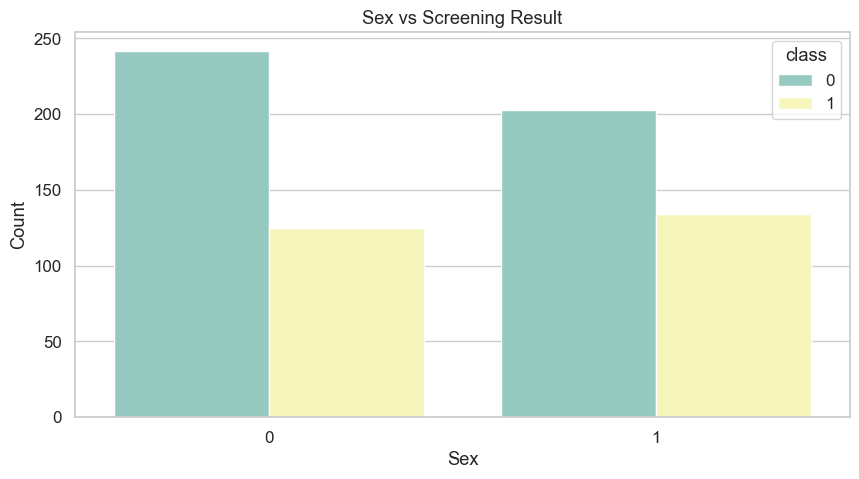

In [36]:
# 3. Plot: Counts of classes by sex
# Join features + target into one DataFrame
df_plot = X.join(y.rename("class"))

# Sex vs Class
plt.figure(figsize=(10,5))
sns.countplot(x="sex", hue="class", data=df_plot, palette="Set3")
plt.title("Sex vs Screening Result")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.savefig("plot_sex_vs_class2.png")
plt.show()

**Observations on sex vs class plot:**
Both male and female respondents had a larger proportion of Class 0 results than Class 1 results. Overall there is a greater number of female respondents in Class 1.

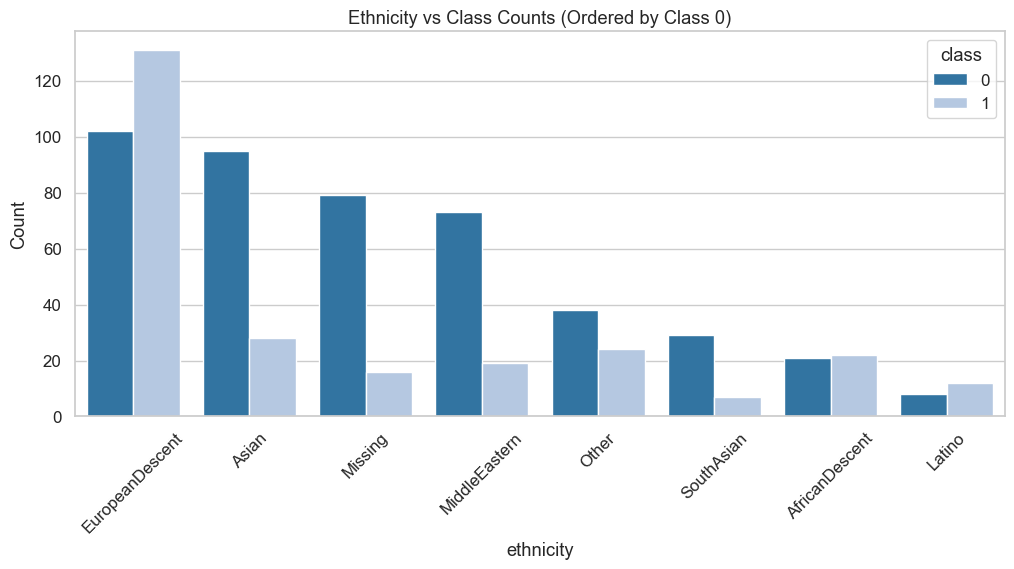

In [37]:
# 4. Plot: Counts of classes by ethnicity
# Join features + target into one DataFrame
df_plot = X.join(y.rename("class"))

# Ethnicity vs Class, ordered by Class 0 counts desc
# Get ethnicity counts for Class 0
eth_order = (
    df_plot[df_plot["class"] == 0]["ethnicity"]
    .value_counts()
    .index
)

plt.figure(figsize=(12,5))

sns.countplot(
    x="ethnicity",
    hue="class",
    data=df_plot,
    order=eth_order,          # order by Class 0 frequency
    palette="tab20"
)
plt.title("Ethnicity vs Class Counts (Ordered by Class 0)")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.savefig("ethnicity_vs_class2.png")
plt.show()

**Observations on ethnicity vs class plot:** 
- Among the eight ethnic groups, five show more respondents in Class 0 than in Class 1.
- EuropeanDescent is the standout exception, with the largest relative number of Class 1 respondents compared to Class 0.
- The Contingency table (*below*), shows that the Latino group has the greater proportion of Class 1 respondents compared to Class 0.

In [38]:
# Contingency table of proportion of class=1 cases by ethnicity (sorted top 10 ethnicities):

# Join ethnicity + class into one DataFrame
df_eth = X[["ethnicity"]].join(y.rename("class"))

# Count table
counts = pd.crosstab(df_eth["ethnicity"], df_eth["class"])

# Add totals and proportions
counts["total"] = counts.sum(axis=1)
counts["prop_class1"] = counts[1] / counts["total"]

# Sort by proportion of Class 1 (descending)
summary = counts.sort_values("prop_class1", ascending=False)

summary.head(10)  # top 10 ethnicities by Class 1 proportion

class,0,1,total,prop_class1
ethnicity,,,,
Latino,8,12,20,0.600000
EuropeanDescent,102,131,233,0.562232
AfricanDescent,21,22,43,0.511628
Other,38,24,62,0.387097
Asian,95,28,123,0.227642
MiddleEastern,73,19,92,0.206522
SouthAsian,29,7,36,0.194444
Missing,79,16,95,0.168421


C:\Users\dell\AppData\Local\Temp\ipykernel_15340\1301339714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


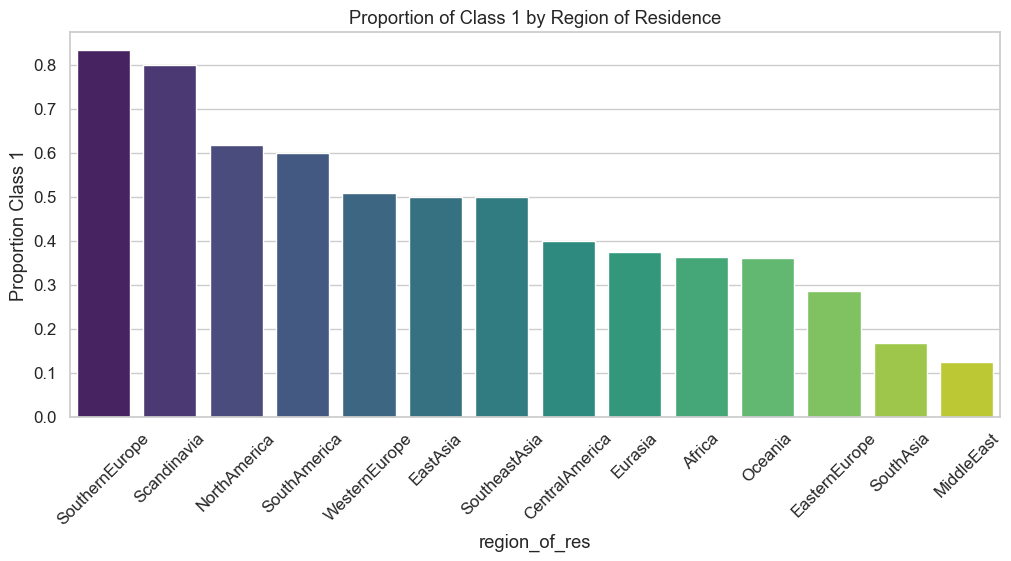

class,0,1,prop_class1
region_of_res,,,
SouthernEurope,1,5,0.833333
Scandinavia,1,4,0.800000
NorthAmerica,52,84,0.617647
SouthAmerica,6,9,0.600000
WesternEurope,58,60,0.508475
EastAsia,1,1,0.500000
SoutheastAsia,8,8,0.500000
CentralAmerica,3,2,0.400000
Eurasia,5,3,0.375000


In [39]:
## Barplot of proportion: region of residence vs class

# Crosstab of region vs class
region_ct = pd.crosstab(df_plot["region_of_res"], df_plot["class"])

# Add proportion of Class 1
region_ct["prop_class1"] = region_ct[1] / region_ct.sum(axis=1)

# Sort by proportion of Class 1
region_ct_sorted = region_ct.sort_values("prop_class1", ascending=False)

# Plot proportions
plt.figure(figsize=(12,5))
sns.barplot(
    x=region_ct_sorted.index,
    y=region_ct_sorted["prop_class1"],
    palette="viridis"
)
plt.title("Proportion of Class 1 by Region of Residence")
plt.xticks(rotation=45)
plt.ylabel("Proportion Class 1")
plt.savefig("barplot_proportion_region_vs_class1_3.png")
plt.show()

region_ct_sorted


**Observations on barplot of proportion of region vs class1:** People residing in the "SouthernEurope" and "Scandinavia" regions have the highest proportions of Class 1 scores, whilst those in the "SouthAsia" and "MiddleEast" region had the lowest. We could also see this on the descending bar plot, i.e. that respondents living in the MiddleEast reduced their assigment to Class=1. 

### **Preprocessing Pipelines & Feature Engineering**

In [40]:
## Preprocessing: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [41]:
## Defining and apply preprocessing Pipelines
# 2. Define feature groups

# Define the AQ-10 item columns
aq_scores = [f"A{i}_Score" for i in range(1, 11)]

# Define feature groups
numeric_cols = ["age"]
binary_cols = aq_scores + ["sex","jaundice","family_pdd","used_app_before"]
categorical_cols = ["ethnicity","region_of_res","relation","age_bin"]

# 3. Define preprocessing pipelines
binary_pipe = Pipeline([ ("impute", SimpleImputer(strategy="most_frequent")) ])

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("bin", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"))
])

categorical_pipe = Pipeline([ ("onehot", OneHotEncoder(handle_unknown="ignore")) ])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols),
    ("bin", binary_pipe, binary_cols)
])

# Fit + transform
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

# If you want feature names for later inspection:
feature_names = (
    numeric_cols +
    list(preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)) +
    binary_cols
)

### **Feature Selection**

In [42]:
## 1. Forward feature selection: need to reduce features from 45 to a more usable set

sfs = SequentialFeatureSelector(
    LogisticRegression(max_iter=1000, random_state=11),
    n_features_to_select="auto", 
    direction="forward",
    cv=5
)
sfs.fit(X_train_prep, y_train)

# Mask of selected features
selected_mask = sfs.get_support()
selected_features = [f for f, keep in zip(feature_names, selected_mask) if keep]
print("Selected features:", selected_features)

Selected features: ['ethnicity_AfricanDescent', 'ethnicity_Latino', 'ethnicity_Other', 'region_of_res_Africa', 'region_of_res_CentralAmerica', 'region_of_res_EastAsia', 'region_of_res_EasternEurope', 'region_of_res_Eurasia', 'region_of_res_Oceania', 'region_of_res_Scandinavia', 'region_of_res_SouthAsia', 'region_of_res_SoutheastAsia', 'region_of_res_SouthernEurope', 'relation_Healthcare_provider', 'relation_Other', 'relation_Parent_Relative', 'age_bin_35-49', 'age_bin_50-64', 'A5_Score', 'A6_Score', 'A9_Score', 'sex', 'used_app_before']


In [43]:
## 2. Backward Feature selection: need to reduce features from 45 to a more usable set

sfs_backward = SequentialFeatureSelector(
    LogisticRegression(max_iter=1000, random_state=11),
    n_features_to_select="auto", 
    direction="backward",
    cv=5
)
sfs_backward.fit(X_train_prep, y_train)

# Mask of selected features
selected_mask_backward = sfs_backward.get_support()
selected_features_backward = [f for f, keep in zip(feature_names, selected_mask_backward) if keep]
print("Backward-selected features:", selected_features_backward)

Backward-selected features: ['ethnicity_EuropeanDescent', 'ethnicity_Other', 'region_of_res_SoutheastAsia', 'relation_Other', 'relation_Parent_Relative', 'relation_Self', 'age_bin_25-34', 'age_bin_35-49', 'age_bin_50-64', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'sex', 'jaundice', 'family_pdd', 'used_app_before']


**Feature Selection:** *23 predictors selected,  22 features dropped*, the same number for both forward and backward selection. Backward selection retains more of the actual scores used to classify "autism likely"/"autism not likely", but forward selection retains more of the supporting data features, including the three strongest AQ-10 score
features. We will proceed with the features identified by forward feature selection. 

### **Visualise the selected features vs Class=1**

In [44]:
## Build dataframe for plotting
# X = your predictors (with original categorical columns, not one-hot encoded)
# y = your target Series/DataFrame with column 'class'

df = X.join(y.rename("class"))

In [45]:
## Selected features after forward SFS

# Selected binary features
selected_binary_feats = ["A5_Score", "A6_Score", "A9_Score", "sex", "used_app_before"]

# Selected categorical categories (from SFS output)
selected_categories = {
    "ethnicity": ["AfricanDescent", "Latino", "Other"],
    "region_of_res": ["Africa", "EastAsia", "EasternEurope", "Eurasia",
                      "CentralAmerica", "Oceania", "Scandinavia",
                      "SouthAsia", "SoutheastAsia", "SouthernEurope"],
    "relation": ["Healthcare_provider", "Other", "Parent_Relative"],
    "age_bin": ["35-49", "50-64"]
}

In [46]:
## Compute conditional probabilities

results = []
baseline = df['class'].mean()

# Categorical features: compare each selected category to baseline
for col, cats in selected_categories.items():
    for cat in cats:
        rate = df.loc[df[col] == cat, 'class'].mean()
        diff = rate - baseline
        results.append({"feature": col, "category": cat, "diff": diff})

# Binary features: compare class=1 rate when feature=1 vs 0
for feat in selected_binary_feats:
    rates = df.groupby(feat)['class'].mean()
    if 1 in rates and 0 in rates:
        diff = rates[1] - rates[0]
        results.append({"feature": feat, "category": "1 vs 0", "diff": diff})

In [47]:
## Prep for plots
summary_df = pd.DataFrame(results)

# Combine feature + category for labeling
summary_df['label'] = summary_df['feature'] + ": " + summary_df['category']

# Sort by absolute effect size
summary_df = summary_df.sort_values("diff", ascending=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_15340\3935377681.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


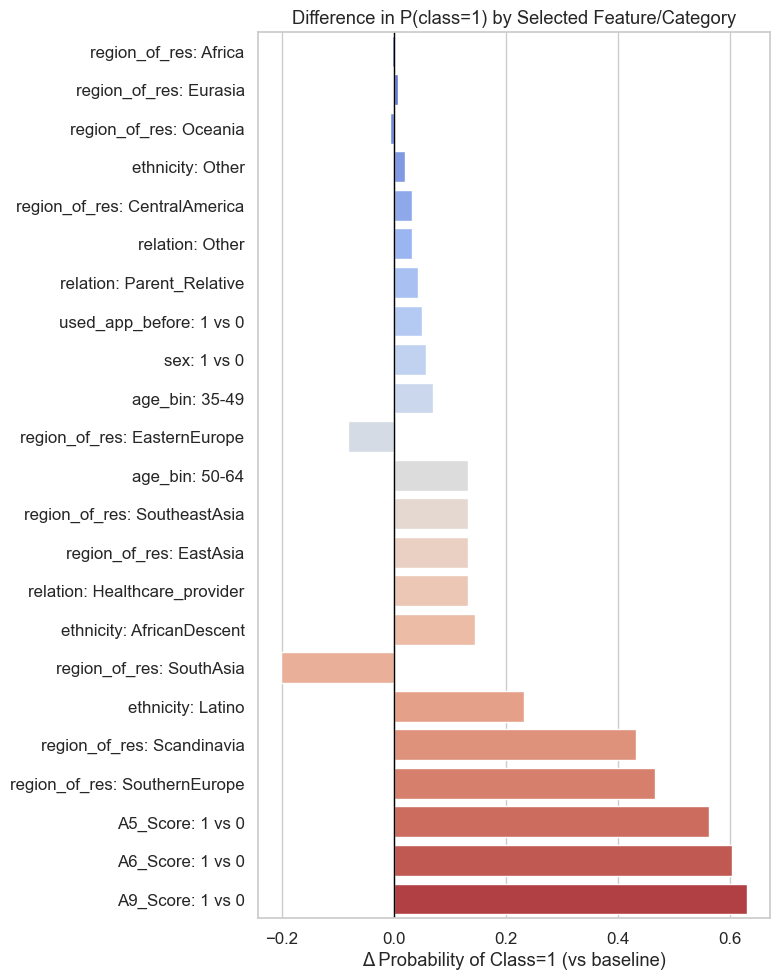

In [48]:
## Plot horizontal barplot - seleted features

# Sort by absolute effect size
summary_df = summary_df.sort_values("diff", key=abs, ascending=True)

plt.figure(figsize=(8, 10))
sns.barplot(
    data=summary_df,
    y="label", x="diff",
    palette="coolwarm", orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Difference in P(class=1) by Selected Feature/Category")
plt.xlabel("Δ Probability of Class=1 (vs baseline)")
plt.ylabel("")
plt.tight_layout()

# Save high-res for PowerPoint
plt.savefig("selected_features_effects3.png", dpi=300, bbox_inches="tight")
plt.show()

Observations on strength of predictors following feature selection: three of the AQ-10 scores are the strongest predictors. Respondents living in SouthernEurope 
and Scandinavia, and ethnicity=Latino. region_of_res=SouthAsia *descreases* the chance of class=1

### **Modelling**

#### **Model 1:** Logistic Regression

In [49]:
# 1. Model1: Logistic Regression on selected features 

# Transform train/test to the reduced feature set
X_train_sel = sfs.transform(X_train_prep)
X_test_sel  = sfs.transform(X_test_prep)

# Define parameter grid for Logistic Regression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear'] 
}

# Initialize base model
logreg = LogisticRegression(max_iter=2000, random_state=44)

# Initialise GridSearch
clf = GridSearchCV(logreg, lr_params, cv=5, scoring='accuracy')
clf.fit(X_train_sel, y_train)

# Evaluate best model
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.8917509481668773


#### LogisticRegression best fit and ROC curve

,Feature,Coefficient,OddsRatio
18,A5_Score,2.172653,8.781555
20,A9_Score,2.089240,8.078773
19,A6_Score,1.766331,5.849351
11,region_of_res_SoutheastAsia,0.804411,2.235380
12,region_of_res_SouthernEurope,0.682387,1.978596
1,ethnicity_Latino,0.428293,1.534636
17,age_bin_50-64,0.307006,1.359348
9,region_of_res_Scandinavia,0.276452,1.318443
13,relation_Healthcare_provider,0.272419,1.313137
2,ethnicity_Other,0.249519,1.283408



Classification Report: LogisticRegression Best Model Test Set:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        89
           1       0.87      0.77      0.82        52

    accuracy                           0.87       141
   macro avg       0.87      0.85      0.86       141
weighted avg       0.87      0.87      0.87       141



<Figure size 640x480 with 0 Axes>

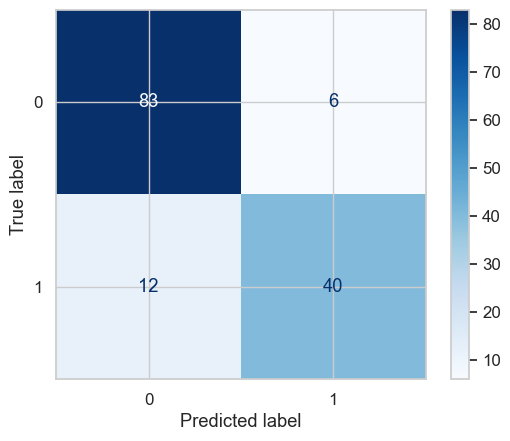

In [50]:
# 2. Model1: Prediction on best LogReg model, confusion matrix, classification report
plt.clf()

# Extract best model 
best_logreg = clf.best_estimator_

# Train a classifier and get predicted probabilities
y_pred_lr = best_logreg.predict(X_test_sel)
y_pred_proba = best_logreg.predict_proba(X_test_sel)[:, 1]

# Inspect coefficients
coef_table = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": best_logreg.coef_[0],
    "OddsRatio": np.exp(best_logreg.coef_[0])
}).sort_values(by="OddsRatio", ascending=False)

display(coef_table)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm, display_labels=best_logreg.classes_).plot(cmap="Blues")     

# Classification report 
print("\nClassification Report: LogisticRegression Best Model Test Set:")
print(classification_report(y_test, y_pred_lr))

**Observations on coeffs:** Using the best model for coeffs dropped the number of features with higher odds of an autism‑indicated screening result from 16 to 13 features.

**Features with the highest OddsRatio:**
After finding best model: Only three of six AQ-10 features are retained.  Two features dropped into the "ambigious" category (Odds Ratio ~ 1, no clear effect).

**Logistic Regression Confusion Matrix:** true negatives: 83, false negatives (misses): 12, false positives: 6, true positives: 40
This model correctly identified 83 negatives and 40 positives. It made 6 false alarms (false positives) and missed 12 true cases (false negatives).

**Logistic Regression Classification Report:**
Strong overall performance (accuracy 87%)
Precision (Class 1): 87% most positive predictions are correct
Recall (Class 1): 77%, capturing ~3/4 true positives
F1 (Class 1): 82% balanced trade off between precision and recall
Recall (Class 0): 93%, "very few false alarms"

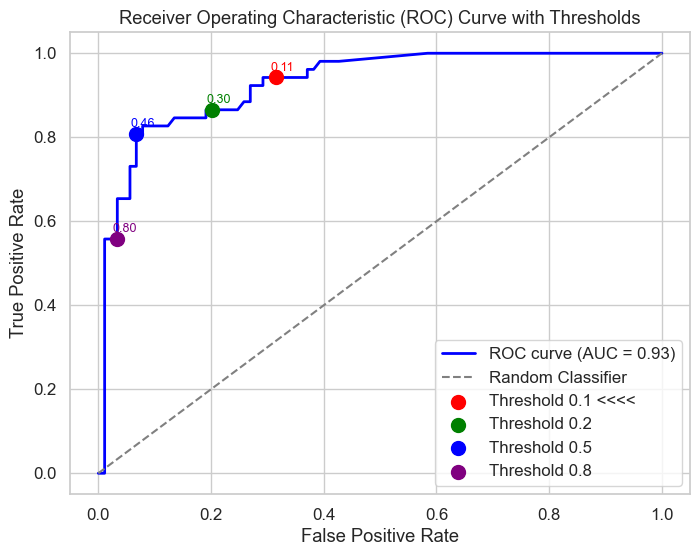

--- Logistic Regression Best Model Accuracies ---
Train Accuracy: 0.8987566607460036
Test Accuracy: 0.8723404255319149
AUC: 0.9281547104580813


In [51]:
# 3. Model1: LogisticRegression prediction, ROC curve with BEST model, Performance

# Calculate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Highlight specific thresholds at 0.15, 0.3, 0.5, and 0.8
highlight_thresholds = [0.1, 0.3, 0.5, 0.8]
colors = ['red', 'green', 'blue', 'purple']
labels = ['Threshold 0.1 <<<<', 'Threshold 0.2', 'Threshold 0.5', 'Threshold 0.8']

for i, threshold_val in enumerate(highlight_thresholds):
    # Find the index of the threshold closest to the desired value
    idx = (abs(thresholds - threshold_val)).argmin()
    plt.scatter(fpr[idx], tpr[idx], marker='o', s=100, color=colors[i], label=labels[i], zorder=5)
    plt.annotate(f'{thresholds[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, color=colors[i])

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# LogisticRegression, performance
train_score = best_logreg.score(X_train_sel, y_train)
test_score  = best_logreg.score(X_test_sel, y_test)

print("--- Logistic Regression Best Model Accuracies ---")
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)
print("AUC:", roc_auc_score(y_test, y_pred_proba))

**Observations on Logistic Regression ROC:**
On the ROC curve: Threshold ≈ 0.1 corresponds to a point with high sensitivity (>0.9) and low false positive rate (~0.1). This cut-off catches most true positives, while keeping false positives relatively low.


#### **Model 2:** Categorical Naïve Bayes

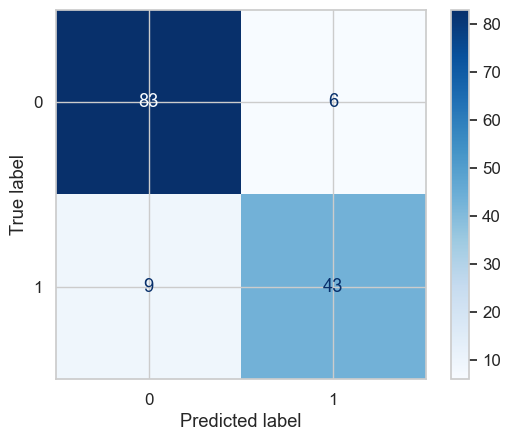

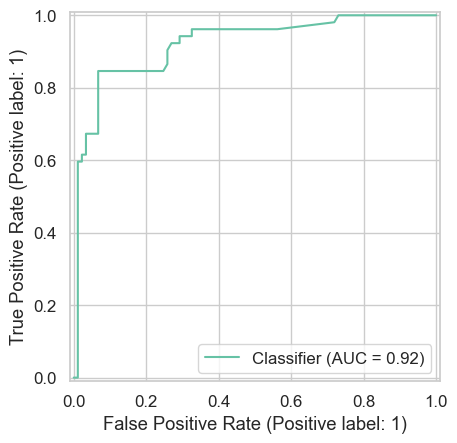

In [52]:
# 1. Model2: Naïve Bayes (CategoricalNB)

# Fit Naïve Bayes
nb = CategoricalNB()
nb.fit(X_train_sel, y_train)

# Predictions
y_pred_nb = nb.predict(X_test_sel)
y_prob_nb = nb.predict_proba(X_test_sel)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cm, display_labels=nb.classes_).plot(cmap="Blues")

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob_nb)

In [53]:
# 2. Model2 Naïve Bayes (CategoricalNB)

print("\nClassification Report: SVM Best Model Test Set:")
print(classification_report(y_test, y_pred_nb))

# Evaluation
print("--- Naïve Bayes Accuracies ---")
print("Train Accuracy:", accuracy_score(y_train, nb.predict(X_train_sel)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_nb))
print("AUC:", roc_auc_score(y_test, y_prob_nb))


Classification Report: SVM Best Model Test Set:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        89
           1       0.88      0.83      0.85        52

    accuracy                           0.89       141
   macro avg       0.89      0.88      0.88       141
weighted avg       0.89      0.89      0.89       141

--- Naïve Bayes Accuracies ---
Train Accuracy: 0.8863232682060391
Test Accuracy: 0.8936170212765957
AUC: 0.9212402765773552


**Observations on Naïve Bayes:**  
- Naïve Bayes has higher accuracy, recall, and F1 than Logistic Regression, also has a strong AUC of 0.92.
- Both models are very precise (few false positives), but Naïve Bayes catches more true positives (43 vs 40).
- Logistic Regression is slightly more conservative (fewer positives predicted), while Naïve Bayes is a bit more balanced.

**Naïve Bayes Confusion Matrix:** true negatives: 83, false negatives (misses): 9, false positives: 6, true positives: 43
This model correctly identified 83 negatives and 43 positives. It made 6 false alarms (false positives) and missed 9 true cases (false negatives).

#### **Model 3:** Support Vector Machine

In [54]:
# 1. Model3: Support Vector Machine 

# Define pipeline with scaling and SVM
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))  # Leave kernel/C/gamma flexible for GridSearch
])

In [55]:
# TEST SMALLER PARAM SET TO MANAGE RUN TIME 
# Define parameter grid for GridSearchCV
svc_params = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.001, 0.0001],
    'svm__kernel': ['linear', 'rbf','poly']
}

In [56]:
# Run GridSearchCV on the pipeline
svm_grid = GridSearchCV(
    estimator=svm_pipe, 
    param_grid=svc_params, 
    cv=5, 
    scoring='accuracy'
)

In [57]:
# Fit the model to the selected features
svm_grid.fit(X_train_sel, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [0.001, 0.0001],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [58]:
# Evaluate best model
print("Best parameters:", svm_grid.best_params_)

print("\nClassification Report: SVM Best Model Test Set:")

y_pred_svm = svm_grid.predict(X_test_sel)
print(classification_report(y_test, y_pred_svm))

Best parameters: {'svm__C': 10, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}

Classification Report: SVM Best Model Test Set:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        89
           1       0.85      0.75      0.80        52

    accuracy                           0.86       141
   macro avg       0.86      0.84      0.84       141
weighted avg       0.86      0.86      0.86       141



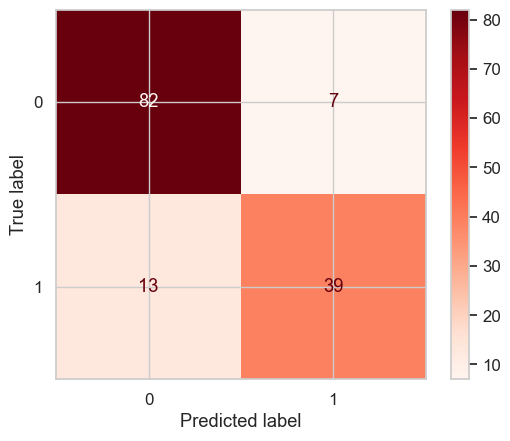

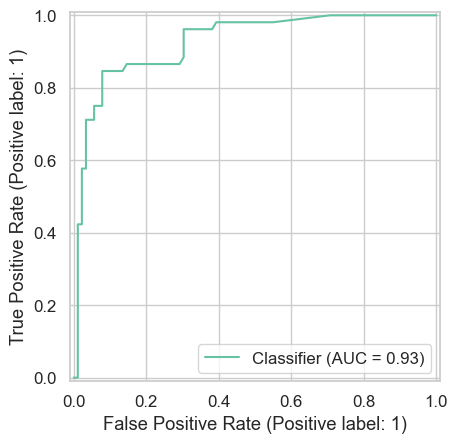

In [59]:
# 2. Model3: Support Vector Machine

# SVM Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm, display_labels=svm_grid.classes_).plot(cmap="Reds")

y_prob_svm = svm_grid.predict_proba(X_test_sel)[:,1]
RocCurveDisplay.from_predictions(y_test, y_prob_svm)

**SVM  Confusion Matrix:** true negatives: 82, false negatives (misses): 13, false positives: 7, true positives: 39
This model correctly identified 82 negatives and 39 positives. It made 7 false alarms (false positives) and missed 13 true cases (false negatives).

**Support Vector Machine Classification Report:**
- Strong overall performance (accuracy 86%)
- Precision (Class 1): 87%, most positive predictions are correct
- Recall (Class 1): 75%, capturing (3/4 true positives)
- F1 (Class 1): 80%, balanced trade off between precision and recall
- Recall (Class 0): 93%, very few false alarms

In [60]:
# 3. Model3: Support Vector Machine

# Evaluate test and train accuracy using best model
print("--- Support Vector Machine Accuracies ---")
print("Best cross-validated accuracy across 5-folds:", svm_grid.best_score_)
print("Train accuracy:", svm_grid.score(X_train_sel, y_train))
print("Test accuracy:", svm_grid.score(X_test_sel, y_test))
print("AUC:", roc_auc_score(y_test, y_prob_svm))

--- Support Vector Machine Accuracies ---
Best cross-validated accuracy across 5-folds: 0.8846554993678888
Train accuracy: 0.8863232682060391
Test accuracy: 0.8581560283687943
AUC: 0.926210025929127


**Observations on Support Vector Machines:** With a test accuracy of 85.8%, this model performed fairly well, and was similar in performance to LogReg(87.2%), but lagging behind CatNB(92.1%).
Trialling different parameters, the combo C=1, gamma=0.0001, kernel='linear', returned an AUC of 88%, we were able to improve this to 93% with further runs (again trying to manage run time to prevent notebook kernel stalling.

### **Compare Models - ROC curve**

<Figure size 640x480 with 0 Axes>

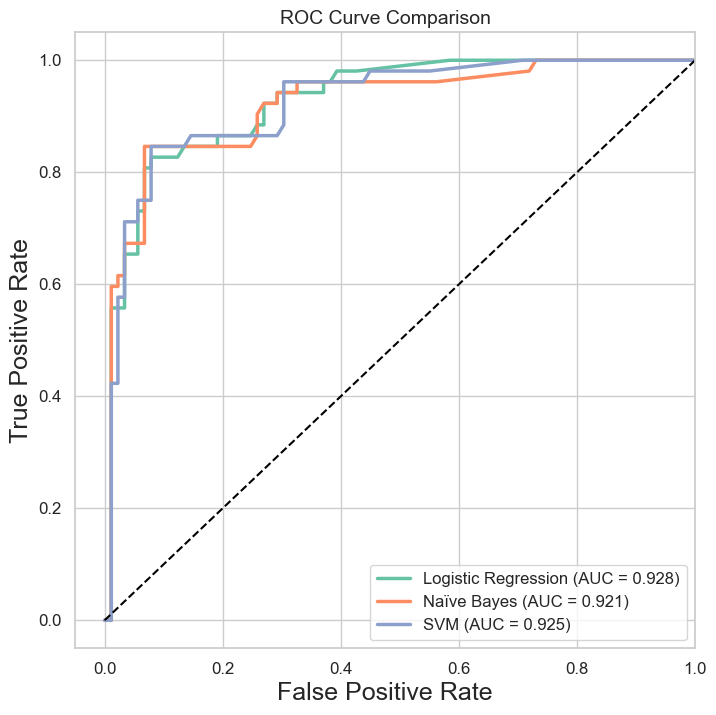

In [61]:
## Compare Models
plt.clf()
# Predict probabilities
y_proba_nb = nb.predict_proba(X_test_sel)[:, 1]

y_proba_lr = best_logreg.predict_proba(X_test_sel)[:, 1]

best_svm = svm_grid.best_estimator_
y_proba_svm = best_svm.decision_function(X_test_sel)


# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

# Compute AUCs
auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)
auc_svm = auc(fpr_svm, tpr_svm)

# Plot all curves
plt.figure(figsize=[8,8])
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2.5)
plt.plot(fpr_nb, tpr_nb, label=f'Naïve Bayes (AUC = {auc_nb:.3f})', linewidth=2.5)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})', linewidth=2.5)

# ROC Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.savefig("ROC Curve logreg_nb_svm3.png")
plt.show()

In [62]:
print("AUC for Logistic Regression ROC:", auc_lr)
print("AUC for categorical NaiveBayes ROC:", auc_nb)
print("AUC for Support Vector Machine ROC:", auc_svm)

AUC for Logistic Regression ROC: 0.9281547104580813
AUC for categorical NaiveBayes ROC: 0.9212402765773552
AUC for Support Vector Machine ROC: 0.9251296456352636


**Observations on comparison ROC:** Best AUC is from Logistic Regression (0.928), which also takes the greatest number of steps, leading to a smoother curve. 

All models were run with threshold total scores >=7. Then, realising the data did not correspond to the published threshold (ie. published threshold is >=6, but result=6 was only classified as "No">>>0 in the data), we reran the models.
The slides demonstrate the model output covered by both the original run, with the higher threshold, and the later run with the "corrected" threshold. The change was to input the **Redefine AQ-10 score threshold for class assignment** section, and rerun the notebook from there down.

Comparing confusion matrices, and test accuracies, Naïve Bayes performed best. Overall findings were that Logistic Regression would be the model best suited to this dataset given that it performs best, independently of the threshold used.